In [1]:
import librosa
import librosa.display
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,AveragePooling2D,ZeroPadding2D,BatchNormalization

Using TensorFlow backend.


In [2]:
y, sr = librosa.load('/home/daniel/datatest/nine/d8ee4734_nohash_0.wav',sr=16000,duration=10)

In [3]:
plt.figure()
plt.subplot(3, 1, 1)
librosa.display.waveplot(y, sr=sr)
plt.title('Monophonic')

In [4]:
plt.figure(figsize=(12, 8))
D = librosa.amplitude_to_db(librosa.stft(y), ref=np.max)
plt.subplot(4, 2, 1)
librosa.display.specshow(D, y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title('Linear-frequency power spectrogram')

/home/daniel/anaconda/lib/python2.7/site-packages/librosa/core/spectrum.py:958: UserWarning: amplitude_to_db was called on complex input so phase information will be discarded. To suppress this warning, call amplitude_to_db(magphase(D)[0]) instead.
  warnings.warn('amplitude_to_db was called on complex input so phase '


In [5]:
plt.subplot(4, 2, 2)
librosa.display.specshow(D, y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Log-frequency power spectrogram')

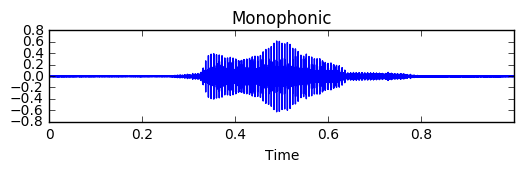

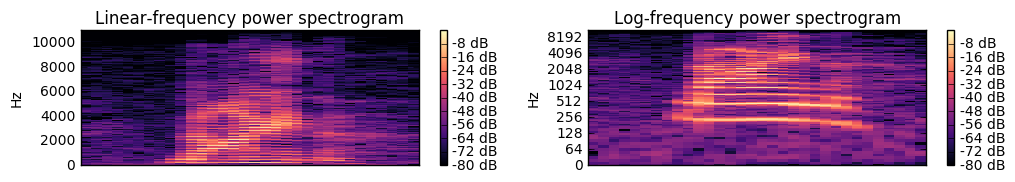

In [6]:
plt.show()

In [2]:
DATA_PATH = "/home/daniel/data/"

In [3]:
hop_length = 320

## LOAD DATA

In [4]:
import numpy as np
import os

DATA_PATH = "/home/daniel/data/"

# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)


In [5]:
labels, _, _ = get_labels(DATA_PATH)
labels

['marvin',
 'happy',
 'six',
 'up',
 'stop',
 'yes',
 'sheila',
 'zero',
 'dog',
 'right',
 'house',
 'no',
 'two',
 'left',
 'cat',
 'nine',
 'seven',
 'three',
 'wow',
 'bed']

## CONVERT WAV TO MFCC

In [109]:
# Handy function to convert wav2mfcc
def wav2mfcc(file_path, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = wave[::3] #downsampling, 
    mfcc = librosa.feature.mfcc(wave,hop_length=hop_length, sr=16000,n_mfcc=26,n_fft=int(16000*0.04))

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]
    
    return mfcc

## SAVE DATA TO FILE NPY

In [110]:
def save_data_to_array(path=DATA_PATH, max_len=11):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in wavfiles:
            mfcc = wav2mfcc(wavfile, max_len=max_len)
            mfcc_vectors.append(mfcc)
        np.save(label + '.npy', mfcc_vectors)

## SET PROPORTION FOR DATA TRAINING AND DATA TESTING

In [111]:
def get_train_test(split_ratio=0.8, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value= (i + 1)))
        print label
    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size= (1 - split_ratio), random_state=random_state, shuffle=True)

## SET HYPER PARAMETER FOR MODEL

In [112]:

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,Conv1D
from keras.utils import to_categorical

# Second dimension of the feature is dim2
feature_dim_2 = 11

# Save data to array file first
save_data_to_array(max_len=feature_dim_2)

# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

# # Feature dimension
feature_dim_1 = 26
channel = 1
epochs = 25
batch_size = 100
verbose = 1
num_classes = 20

# Reshaping to perform 2D convolution
X_train = X_train.reshape(X_train.shape[0], feature_dim_1, feature_dim_2, channel)
X_test = X_test.reshape(X_test.shape[0], feature_dim_1, feature_dim_2, channel)

y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

happy
six
up
stop
yes
sheila
zero
dog
right
house
no
two
left
cat
nine
seven
three
wow
bed


In [113]:
# Predicts one sample
def predict(filepath, model):
    sample = wav2mfcc(filepath)
    sample_reshaped = sample.reshape(1, feature_dim_1, feature_dim_2, channel)
    return get_labels()[0][
            np.argmax(model.predict(sample_reshaped))
    ]

## INTIALIZE MODEL LENET ARCHITECTURE

In [114]:
def model_lenet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [115]:
model = model_lenet()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
  600/27200 [..............................] - ETA: 6:57 - loss: 6.5776 - acc: 0.0533 

/home/daniel/anaconda/lib/python2.7/site-packages/keras/callbacks.py:120: UserWarning: Method on_batch_end() is slow compared to the batch update (0.441631). Check your callbacks.
  % delta_t_median)


27200/27200 [==============================] - 24s 870us/step - loss: 2.3585 - acc: 0.2899 - val_loss: 1.8189 - val_acc: 0.4278
Epoch 2/25
27200/27200 [==============================] - 16s 592us/step - loss: 1.5333 - acc: 0.5125 - val_loss: 1.4884 - val_acc: 0.5231
Epoch 3/25
27200/27200 [==============================] - 15s 537us/step - loss: 1.2651 - acc: 0.5965 - val_loss: 1.3272 - val_acc: 0.5838
Epoch 4/25
27200/27200 [==============================] - 16s 590us/step - loss: 1.1143 - acc: 0.6424 - val_loss: 1.2570 - val_acc: 0.6079
Epoch 5/25
27200/27200 [==============================] - 15s 557us/step - loss: 0.9942 - acc: 0.6786 - val_loss: 1.1605 - val_acc: 0.6397
Epoch 6/25
27200/27200 [==============================] - 14s 502us/step - loss: 0.9153 - acc: 0.7060 - val_loss: 1.1447 - val_acc: 0.6453
Epoch 7/25
27200/27200 [==============================] - 14s 511us/step - loss: 0.8430 - acc: 0.7260 - val_loss: 1.1712 - val_acc: 0.6441
Epoch 8/25
27200/27200 [==============

## INITIALIZE MODEL LENET WITH KERNEL WITH 2x2 KERNEL

In [116]:
def model_lenet_modk2():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(2, 2), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    #model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(2, 2),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [126]:
model = model_lenet_modk2()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 11s 415us/step - loss: 3.0680 - acc: 0.2806 - val_loss: 2.0366 - val_acc: 0.3671
Epoch 2/25
27200/27200 [==============================] - 8s 284us/step - loss: 1.4581 - acc: 0.5445 - val_loss: 1.3223 - val_acc: 0.5868
Epoch 3/25
27200/27200 [==============================] - 8s 289us/step - loss: 1.1172 - acc: 0.6504 - val_loss: 1.1727 - val_acc: 0.6284
Epoch 4/25
27200/27200 [==============================] - 8s 286us/step - loss: 0.9257 - acc: 0.7028 - val_loss: 1.1573 - val_acc: 0.6425
Epoch 5/25
27200/27200 [==============================] - 8s 285us/step - loss: 0.7769 - acc: 0.7518 - val_loss: 1.1591 - val_acc: 0.6457
Epoch 6/25
27200/27200 [==============================] - 8s 300us/step - loss: 0.6567 - acc: 0.7901 - val_loss: 1.1820 - val_acc: 0.6550
Epoch 7/25
27200/27200 [==============================] - 8s 287us/step - loss: 0.5401 - acc: 0.8289 - val_loss: 1.2643 - 

## INITIALIZE MODEL LENET WITH KERNEL WITH 3x3 KERNEL

In [118]:
def model_lenet_modk3():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(3, 3), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    #model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(3, 3),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [119]:
model = model_lenet_modk3()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 9s 341us/step - loss: 4.2789 - acc: 0.1697 - val_loss: 2.1791 - val_acc: 0.3199
Epoch 2/25
27200/27200 [==============================] - 9s 319us/step - loss: 1.9375 - acc: 0.3880 - val_loss: 1.7469 - val_acc: 0.4510
Epoch 3/25
27200/27200 [==============================] - 7s 251us/step - loss: 1.5792 - acc: 0.5047 - val_loss: 1.5932 - val_acc: 0.5009
Epoch 4/25
27200/27200 [==============================] - 8s 288us/step - loss: 1.3815 - acc: 0.5627 - val_loss: 1.4285 - val_acc: 0.5446
Epoch 5/25
27200/27200 [==============================] - 7s 273us/step - loss: 1.2382 - acc: 0.6033 - val_loss: 1.4455 - val_acc: 0.5484
Epoch 6/25
27200/27200 [==============================] - 9s 316us/step - loss: 1.1221 - acc: 0.6414 - val_loss: 1.3271 - val_acc: 0.5866
Epoch 7/25
27200/27200 [==============================] - 8s 286us/step - loss: 1.0308 - acc: 0.6694 - val_loss: 1.3507 - v

## INITIALIZE MODEL LENET WITH KERNEL WITH 4x4 KERNEL

In [120]:
def model_lenet_modk4():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(4, 4), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(4, 4),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [121]:
model_k4 = model_lenet_modk4()
model_k4.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 15s 559us/step - loss: 2.7501 - acc: 0.3157 - val_loss: 1.6051 - val_acc: 0.4912
Epoch 2/25
27200/27200 [==============================] - 13s 468us/step - loss: 1.2903 - acc: 0.5931 - val_loss: 1.1591 - val_acc: 0.6393
Epoch 3/25
27200/27200 [==============================] - 13s 468us/step - loss: 0.9903 - acc: 0.6842 - val_loss: 1.2000 - val_acc: 0.6251
Epoch 4/25
27200/27200 [==============================] - 13s 466us/step - loss: 0.8265 - acc: 0.7342 - val_loss: 0.9822 - val_acc: 0.6976
Epoch 5/25
27200/27200 [==============================] - 13s 464us/step - loss: 0.7016 - acc: 0.7740 - val_loss: 0.9364 - val_acc: 0.7141
Epoch 6/25
27200/27200 [==============================] - 13s 470us/step - loss: 0.6007 - acc: 0.8039 - val_loss: 1.0166 - val_acc: 0.6984
Epoch 7/25
27200/27200 [==============================] - 13s 466us/step - loss: 0.5097 - acc: 0.8350 - val_loss: 0.9

## INITIALIZE MODEL LENET WITH KERNEL WITH 6x6 KERNEL

In [122]:
def model_lenet_modk6():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(6, 6), strides=1, activation='relu', input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(6, 6),strides=1, activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2),strides=2))
    model.add(Flatten())
    model.add(Dense(500, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model

In [123]:
model = model_lenet_modk6()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 11s 419us/step - loss: 2.4840 - acc: 0.2727 - val_loss: 1.8462 - val_acc: 0.4184
Epoch 2/25
27200/27200 [==============================] - 10s 373us/step - loss: 1.4581 - acc: 0.5394 - val_loss: 1.3295 - val_acc: 0.5881
Epoch 3/25
27200/27200 [==============================] - 10s 368us/step - loss: 1.1500 - acc: 0.6368 - val_loss: 1.1368 - val_acc: 0.6460
Epoch 4/25
27200/27200 [==============================] - 10s 364us/step - loss: 0.9800 - acc: 0.6898 - val_loss: 1.0239 - val_acc: 0.6815
Epoch 5/25
27200/27200 [==============================] - 10s 360us/step - loss: 0.8549 - acc: 0.7276 - val_loss: 1.1019 - val_acc: 0.6635
Epoch 6/25
27200/27200 [==============================] - 10s 371us/step - loss: 0.7770 - acc: 0.7483 - val_loss: 1.0000 - val_acc: 0.6931
Epoch 7/25
27200/27200 [==============================] - 10s 354us/step - loss: 0.6951 - acc: 0.7747 - val_loss: 0.9

## INITIALIZE MODEL SPNET

In [124]:
def model_spnet():
    model = Sequential()
    model.add(Conv2D(20, kernel_size=(5, 5), activation='relu',strides=4, input_shape=(feature_dim_1, feature_dim_2, channel)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), activation='relu'))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(Conv2D(50, kernel_size=(5, 5), strides=1, activation='relu'))
    model.add(ZeroPadding2D(padding=(2,2)))
    model.add(MaxPooling2D(pool_size=(3, 3)))
    model.add(Flatten())
    model.add(Dense(200, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    return model



In [125]:
model = model_spnet()
model.fit(X_train, y_train_hot, batch_size=batch_size, epochs=epochs, verbose=verbose, validation_data=(X_test, y_test_hot))

Train on 27200 samples, validate on 6800 samples
Epoch 1/25
27200/27200 [==============================] - 9s 336us/step - loss: 2.6813 - acc: 0.1701 - val_loss: 2.1284 - val_acc: 0.3181
Epoch 2/25
27200/27200 [==============================] - 7s 273us/step - loss: 1.9110 - acc: 0.3853 - val_loss: 1.7478 - val_acc: 0.4359
Epoch 3/25
27200/27200 [==============================] - 7s 274us/step - loss: 1.6193 - acc: 0.4725 - val_loss: 1.5898 - val_acc: 0.4885
Epoch 4/25
27200/27200 [==============================] - 7s 275us/step - loss: 1.4633 - acc: 0.5212 - val_loss: 1.5791 - val_acc: 0.4960
Epoch 5/25
27200/27200 [==============================] - 7s 274us/step - loss: 1.3741 - acc: 0.5502 - val_loss: 1.5112 - val_acc: 0.5149
Epoch 6/25
27200/27200 [==============================] - 7s 264us/step - loss: 1.2957 - acc: 0.5760 - val_loss: 1.4780 - val_acc: 0.5318
Epoch 7/25
27200/27200 [==============================] - 7s 271us/step - loss: 1.2316 - acc: 0.5964 - val_loss: 1.4901 - v

In [61]:
spnet = {}
lenet = {}
lenet_k2 = {}
lenet_k3 = {}
lenet_k4 = {}
lenet_k6 = {}

In [62]:
spnet[1] = 0.1742; spnet[5] = 0.5306; spnet[10] = 0.6216; spnet[15] = 0.6828; spnet[20] = 0.7331; spnet[25] = 0.7776; 

In [63]:
lenet[1] = 0.2547; lenet[5] = 0.6647; lenet[10] = 0.7732; lenet[15] = 0.8531; lenet[20] = 0.9156; lenet[25] = 0.9515; 

In [64]:
lenet_k2[1] = 0.2106; lenet_k2[5] = 0.7253; lenet_k2[10] = 0.8722; lenet_k2[15] = 0.9581; lenet_k2[20] = 0.9879; lenet_k2[25] = 0.9918; 

In [65]:
lenet_k3[1] = 0.2335; lenet_k3[5] = 0.6321; lenet_k3[10] = 0.7357; lenet_k3[15] = 0.8156; lenet_k3[20] = 0.8769; lenet_k3[25] = 0.9225; 

In [66]:
lenet_k4[1] = 0.1937; lenet_k4[5] = 0.7469; lenet_k4[10] = 0.8698; lenet_k4[15] = 0.9447; lenet_k4[20] = 0.9782; lenet_k4[25] = 0.9902; 

In [67]:
lenet_k6[1] = 0.2760; lenet_k6[5] = 0.7229; lenet_k6[10] = 0.8186; lenet_k6[15] = 0.8754; lenet_k6[20] = 0.9265; lenet_k6[25] = 0.9574; 

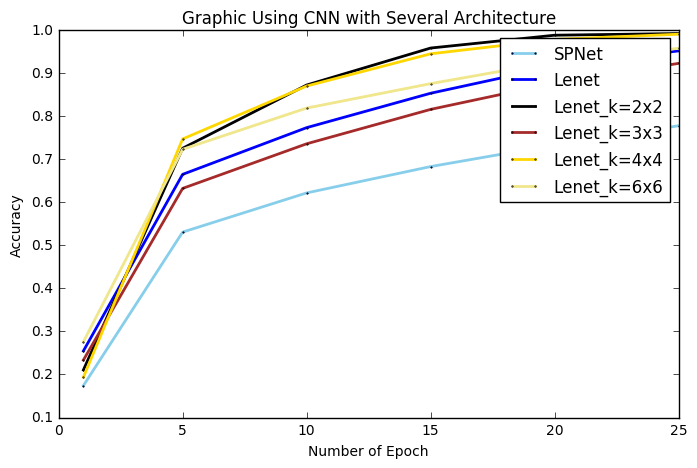

In [68]:
# Data
df=pd.DataFrame({'x': spnet.keys(), 'SPNet': spnet.values(), 'Lenet': lenet.values(), 'Lenet_k=2x2':lenet_k2.values(), 'Lenet_k=3x3':lenet_k3.values(), 'Lenet_k=4x4':lenet_k4.values(), 'Lenet_k=6x6':lenet_k6.values()})
 
# multiple line plot
plt.figure(figsize=(8,5))
plt.plot( 'x', 'SPNet', data=df, marker='o', markerfacecolor='blue', markersize=1, color='skyblue', linewidth=2)
plt.plot( 'x', 'Lenet', data=df, marker='o', markerfacecolor='blue', markersize=1, color='blue', linewidth=2)
plt.plot( 'x', 'Lenet_k=2x2', data=df, marker='o', markerfacecolor='black', markersize=1, color='black', linewidth=2)
plt.plot( 'x', 'Lenet_k=3x3', data=df, marker='o', markerfacecolor='brown', markersize=1, color='brown', linewidth=2)
plt.plot( 'x', 'Lenet_k=4x4', data=df, marker='o', markerfacecolor='gold', markersize=1, color='gold', linewidth=2)
plt.plot( 'x', 'Lenet_k=6x6', data=df, marker='o', markerfacecolor='khaki', markersize=1, color='khaki', linewidth=2)
plt.title('Graphic Using CNN with Several Architecture')
plt.xlabel('Number of Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [69]:
tabel_acc20 = pd.DataFrame([spnet.keys(),spnet.values(),lenet.values(),lenet_k2.values(),lenet_k3.values(),lenet_k4.values(),lenet_k6.values()])
tabel_acc20 = tabel_acc20.T
tabel_acc20.columns = ['number of epoch','SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']
tabel_acc20_val = pd.DataFrame([0.5488,0.6553,0.6729,0.6376,0.7209,0.7182])
tabel_acc20_val = tabel_acc20_val.T
tabel_acc20_val.columns = ['SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']

## MODEL ACCURATION FOR KOEFISIEN 20

In [72]:
tabel_acc20

,number of epoch,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,1.0,0.1742,0.2547,0.2106,0.2335,0.1937,0.2760
1,5.0,0.5306,0.6647,0.7253,0.6321,0.7469,0.7229
2,10.0,0.6216,0.7732,0.8722,0.7357,0.8698,0.8186
3,15.0,0.6828,0.8531,0.9581,0.8156,0.9447,0.8754
4,20.0,0.7331,0.9156,0.9879,0.8769,0.9782,0.9265
5,25.0,0.7776,0.9515,0.9918,0.9225,0.9902,0.9574


## VALIDATION ACCURATION FOR COEFFICIENT 20

In [73]:
tabel_acc20_val

,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,0.5488,0.6553,0.6729,0.6376,0.7209,0.7182


In [99]:
spnet13 = {}
lenet13 = {}
lenet13_k2 = {}
lenet13_k3 = {}
lenet13_k4 = {}
lenet13_k6 = {}

In [100]:
spnet13[1] = 0.1888; spnet13[5] = 0.5500; spnet13[10] = 0.6390; spnet13[15] = 0.6999; spnet13[20] = 0.7510; spnet13[25] = 0.7910; 

In [101]:
lenet13[1] = 0.2245; lenet13[5] = 0.6476; lenet13[10] = 0.7343; lenet13[15] = 0.7928; lenet13[20] = 0.8426; lenet13[25] = 0.8827; 

In [102]:
lenet13_k2[1] = 0.2488; lenet13_k2[5] = 0.6778; lenet13_k2[10] = 0.7887; lenet13_k2[15] = 0.8707; lenet13_k2[20] = 0.9278; lenet13_k2[25] = 0.9587; 

In [103]:
lenet13_k3[1] = 0.2632; lenet13_k3[5] = 0.6074; lenet13_k3[10] = 0.6849; lenet13_k3[15] = 0.7235; lenet13_k3[20] = 0.7619; lenet13_k3[25] = 0.7893; 

In [104]:
lenet13_k4[1] = 0.2781; lenet13_k4[5] = 0.7438; lenet13_k4[10] = 0.8600; lenet13_k4[15] = 0.9314; lenet13_k4[20] = 0.9703; lenet13_k4[25] = 0.9876; 

In [105]:
lenet13_k6[1] = 0.2753; lenet13_k6[5] = 0.7071; lenet13_k6[10] = 0.7800; lenet13_k6[15] = 0.8208; lenet13_k6[20] = 0.8547; lenet13_k6[25] = 0.8854; 

In [106]:
tabel_acc13 = pd.DataFrame([spnet13.keys(),spnet13.values(),lenet13.values(),lenet13_k2.values(),lenet13_k3.values(),lenet13_k4.values(),lenet13_k6.values()])
tabel_acc13 = tabel_acc13.T
tabel_acc13.columns = ['number of epoch','SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']
tabel_acc13_val = pd.DataFrame([0.5566,0.6559,0.6706,0.6353,0.7226,0.7303])
tabel_acc13_val = tabel_acc13_val.T
tabel_acc13_val.columns = ['SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']

## MODEL ACCURATION FOR COEFFICIENT 13

In [107]:
tabel_acc13

,number of epoch,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,1.0,0.1888,0.2245,0.2488,0.2632,0.2781,0.2753
1,5.0,0.5500,0.6476,0.6778,0.6074,0.7438,0.7071
2,10.0,0.6390,0.7343,0.7887,0.6849,0.8600,0.7800
3,15.0,0.6999,0.7928,0.8707,0.7235,0.9314,0.8208
4,20.0,0.7510,0.8426,0.9278,0.7619,0.9703,0.8547
5,25.0,0.7910,0.8827,0.9587,0.7893,0.9876,0.8854


## VALIDATION ACCURATION FOR COEFFICIENT 13

In [108]:
tabel_acc13_val

,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,0.5566,0.6559,0.6706,0.6353,0.7226,0.7303


In [127]:
spnet26 = {}
lenet26 = {}
lenet26_k2 = {}
lenet26_k3 = {}
lenet26_k4 = {}
lenet26_k6 = {}

In [128]:
spnet26[1] = 0.1701; spnet26[5] = 0.5502; spnet26[10] = 0.6429; spnet26[15] = 0.7074; spnet26[20] = 0.7634; spnet26[25] = 0.8062; 

In [129]:
lenet26[1] = 0.0533; lenet26[5] = 0.6786; lenet26[10] = 0.7873; lenet26[15] = 0.8791; lenet26[20] = 0.9398; lenet26[25] = 0.9709;

In [130]:
lenet26_k2[1] = 0.2806; lenet26_k2[5] = 0.7518; lenet26_k2[10] = 0.9089; lenet26_k2[15] = 0.9768; lenet26_k2[20] = 0.9923; lenet26_k2[25] = 0.9879; 

In [131]:
lenet26_k3[1] = 0.1697; lenet26_k3[5] = 0.6033; lenet26_k3[10] = 0.7406; lenet26_k3[15] = 0.8310; lenet26_k3[20] = 0.9044; lenet26_k3[25] = 0.9539; 

In [132]:
lenet26_k4[1] = 0.3157; lenet26_k4[5] = 0.7740; lenet26_k4[10] = 0.9058;  lenet26_k4[15] = 0.9725;  lenet26_k4[20] = 0.9814;  lenet26_k4[25] = 0.9932;

In [133]:
lenet26_k6[1] = 0.2727; lenet26_k6[5] = 0.7276; lenet26_k6[10] = 0.8314; lenet26_k6[15] = 0.8995; lenet26_k6[20] = 0.9441; lenet26_k6[25] = 0.9658; 

In [134]:
tabel_acc26 = pd.DataFrame([spnet26.keys(),spnet26.values(),lenet26.values(),lenet26_k2.values(),lenet26_k3.values(),lenet26_k4.values(),lenet26_k6.values()])
tabel_acc26 = tabel_acc26.T
tabel_acc26.columns = ['number of epoch','SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']
tabel_acc26_val = pd.DataFrame([0.5476,0.6610,0.6719,0.6149,0.7259,0.7310])
tabel_acc26_val = tabel_acc26_val.T
tabel_acc26_val.columns = ['SPNet','Lenet','Lenet k=2x2','Lenet k=3x3','Lenet k=4x4','Lenet k=6x6']

## MODEL ACCURATION FOR COEFFICIENT 26

In [135]:
tabel_acc26

,number of epoch,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,1.0,0.1701,0.0533,0.2806,0.1697,0.3157,0.2727
1,5.0,0.5502,0.6786,0.7518,0.6033,0.7740,0.7276
2,10.0,0.6429,0.7873,0.9089,0.7406,0.9058,0.8314
3,15.0,0.7074,0.8791,0.9768,0.8310,0.9725,0.8995
4,20.0,0.7634,0.9398,0.9923,0.9044,0.9814,0.9441
5,25.0,0.8062,0.9709,0.9879,0.9539,0.9932,0.9658


## VALIDATION ACCURATION FOR COEFFICIENT 26

In [136]:
tabel_acc26_val

,SPNet,Lenet,Lenet k=2x2,Lenet k=3x3,Lenet k=4x4,Lenet k=6x6
0,0.5476,0.661,0.6719,0.6149,0.7259,0.731


In [140]:
sp_graph = {}
lenet_graph = {}
lenet2_graph = {}
lenet3_graph = {}
lenet4_graph = {}
lenet6_graph = {}
sp_graph[13] = 0.5566; lenet_graph[13] = 0.6559; lenet2_graph[13] = 0.6706; lenet3_graph[13] = 0.6353; lenet4_graph[13] = 0.7226; lenet6_graph[13] = 0.7303;
sp_graph[20] = 0.5488; lenet_graph[20] = 0.6581; lenet2_graph[20] = 0.6729; lenet3_graph[20] = 0.6368; lenet4_graph[20] = 0.7209; lenet6_graph[20] = 0.7229;
sp_graph[26] = 0.5476; lenet_graph[26] = 0.661; lenet2_graph[26] = 0.6719; lenet3_graph[26] = 0.6149; lenet4_graph[26] = 0.7259; lenet6_graph[26] = 0.731;

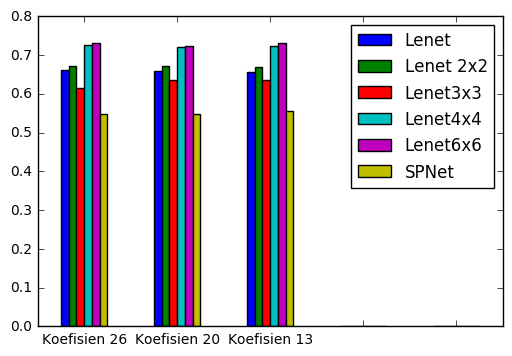

In [141]:
sp = [sp_graph[26],sp_graph[20],sp_graph[13],0,0]
le = [lenet_graph[26],lenet_graph[20],lenet_graph[13],0,0]
le2 = [lenet2_graph[26],lenet2_graph[20],lenet2_graph[13],0,0]
le3 = [lenet3_graph[26],lenet3_graph[20],lenet3_graph[13],0,0]
le4 = [lenet4_graph[26],lenet4_graph[20],lenet4_graph[13],0,0]
le6 = [lenet6_graph[26],lenet6_graph[20],lenet6_graph[13],0,0]
index = ["Koefisien 26",'Koefisien 20','Koefisien 13','','']
df = pd.DataFrame({'SPNet': sp,'Lenet': le,'Lenet 2x2': le2,'Lenet3x3': le3,'Lenet4x4': le4,'Lenet6x6': le6}, index=index)
ax = df.plot.bar(rot=0)
plt.show()

In [142]:
tp = {}
fp = {}
fn = {}

In [143]:
for i in labels:
    tp[i] = 0
    fp[i] = 0
    fn[i] = 0

In [63]:
count = 0
for i in range(0,6800):
    sample = X_test[i].reshape(1, feature_dim_1, feature_dim_2, channel)
    prediction = get_labels()[0][np.argmax(model_k4.predict(sample))]
    real = get_labels()[0][np.argmax(y_test_hot[i])]
    if (real == prediction):
        count+=1
        tp[real]+=1
    else:
        fn[prediction]+=1
        fp[real]+=1

In [74]:
precision = {}
recall = {}
f1 = {}
accurationn = {}
error_rate = {}
for i in labels:
    precision[i] = 0
    recall[i] = 0
    f1[i] = 0
    error_rate[i] = 0

In [75]:
from __future__ import division
for i in labels:
    precision[i] = tp[i]/(tp[i]+fp[i])
    recall[i] = tp[i]/(tp[i]+fn[i])
    f1[i] = 2*(precision[i]*recall[i])/(precision[i]+recall[i])
    error_rate[i] = 1-precision[i]

In [76]:
tabel_acc26_val = pd.DataFrame([precision.keys(),precision.values(),recall.values(),f1.values(),error_rate.values()])
tabel_acc26_val = tabel_acc26_val.T
tabel_acc26_val.columns = ['Label', 'Precision / Accuration', 'Recall', 'F - Measure','Error Rate']

## Confusion Matrix

In [77]:
tabel_acc26_val

,Label,Precision / Accuration,Recall,F - Measure,Error Rate
0,sheila,0.771875,0.732938,0.751903,0.228125
1,seven,0.558282,0.713725,0.626506,0.441718
2,right,0.718654,0.732087,0.725309,0.281346
3,three,0.789017,0.675743,0.728,0.210983
4,no,0.725212,0.616867,0.666667,0.274788
5,marvin,0.839286,0.824561,0.831858,0.160714
6,wow,0.767705,0.87987,0.81997,0.232295
7,six,0.65,0.764706,0.702703,0.35
8,stop,0.683646,0.676393,0.68,0.316354
9,up,0.801802,0.550515,0.652812,0.198198


## EXAMPLE PREDICTION OF VOICE 

In [87]:
print(predict('/home/daniel/data/zero/1c1060b1_nohash_1.wav', model=model_k4))

sheila
